## Import Library

In [2]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [4]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

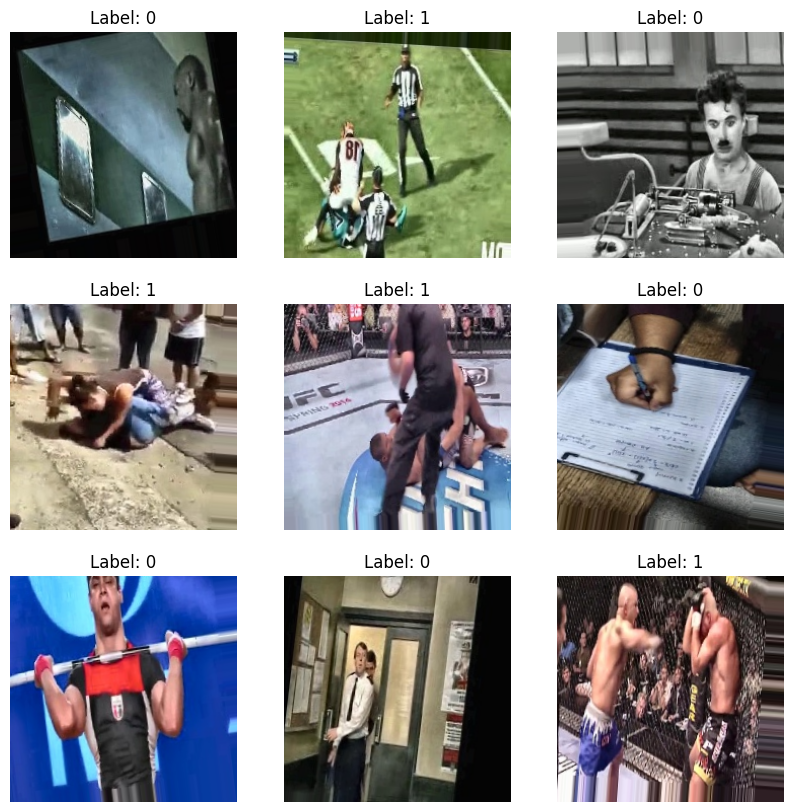

In [5]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [6]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze20_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7424 - loss: 1.2624
Epoch 1: val_accuracy improved from -inf to 0.73636, saving model to MCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 539s 11s/step - accuracy: 0.7429 - loss: 1.2613 - val_accuracy: 0.7364 - val_loss: 1.1688
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8374 - loss: 0.8937
Epoch 2: val_accuracy improved from 0.73636 to 0.85227, saving model to MCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.8375 - loss: 0.8925 - val_accuracy: 0.8523 - val_loss: 0.7071
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8579 - loss: 0.6917
Epoch 3: val_accuracy did not improve from 0.85227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.8581 - loss: 0.6910 - val_accuracy: 0.8341 - val_loss: 0.6823
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8812 - loss: 0.5834
Epoch 4: val_accuracy improved from 0.85227 to 0.89318, saving model to MCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - accuracy: 0.8810 - loss: 0.5837 - val_accuracy: 0.8932 - val_loss: 0.6015
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8711 - loss: 0.6520
Epoch 5: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 0.8711 - loss: 0.6517 - val_accuracy: 0.8068 - val_loss: 0.7398
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8722 - loss: 0.5839
Epoch 6: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - accuracy: 0.8721 - loss: 0.5843 - val_accuracy: 0.8205 - val_loss: 0.6548
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8869 - loss: 0.5441
Epoch 7: val_accuracy did not improve from 0.89318
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8869 - loss: 0.5436 - val_accuracy: 0.8568 - val_loss: 0.6073
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8721 - loss: 0.5475
Epoch 8: val_accuracy did not i

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8690 - loss: 0.5702 - val_accuracy: 0.8977 - val_loss: 0.4911
Epoch 37/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8655 - loss: 0.5707
Epoch 37: val_accuracy did not improve from 0.89773
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.8658 - loss: 0.5707 - val_accuracy: 0.8455 - val_loss: 0.5996
Epoch 38/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8668 - loss: 0.5577
Epoch 38: val_accuracy improved from 0.89773 to 0.90000, saving model to MCLAHE_Freeze20_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.8667 - loss: 0.5578 - val_accuracy: 0.9000 - val_loss: 0.4924
Epoch 39/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8733 - loss: 0.5490
Epoch 39: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.8735 - loss: 0.5486 - val_accuracy: 0.5795 - val_loss: 2.2268
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8742 - loss: 0.5103
Epoch 40: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 603ms/step - accuracy: 0.8740 - loss: 0.5104 - val_accuracy: 0.6500 - val_loss: 1.5125
Epoch 41/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8755 - loss: 0.4962
Epoch 41: val_accuracy did not improve from 0.90000
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 603ms/step - accuracy: 0.8751 - loss: 0.4967 - val_accuracy: 0.8705 - val_loss: 0.5397
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.8785 - loss: 0.5149
Epoch 42: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.8409 - loss: 0.8046
Validation Loss: 1.6670823097229004
Validation Accuracy: 0.625


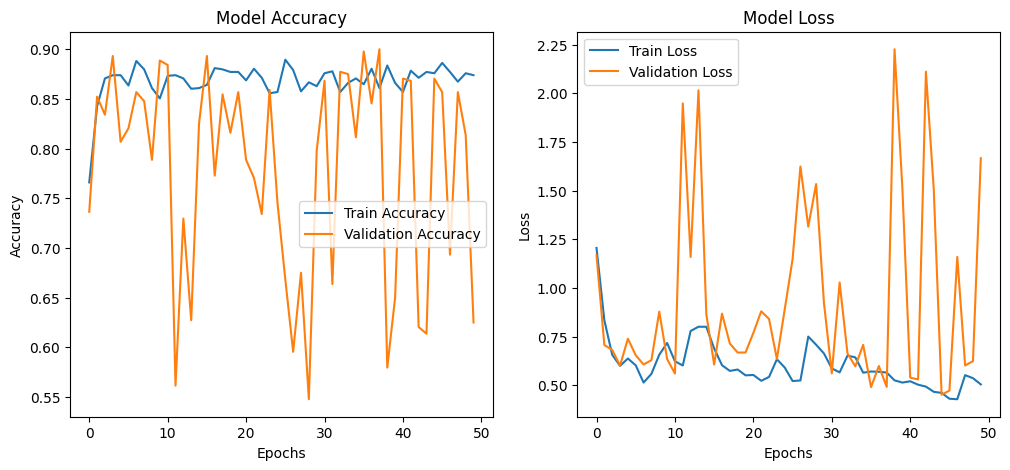

In [8]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [9]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze20_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.8095 - loss: 0.6936
Test Accuracy : 87.39%
Test Loss     : 0.552


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step


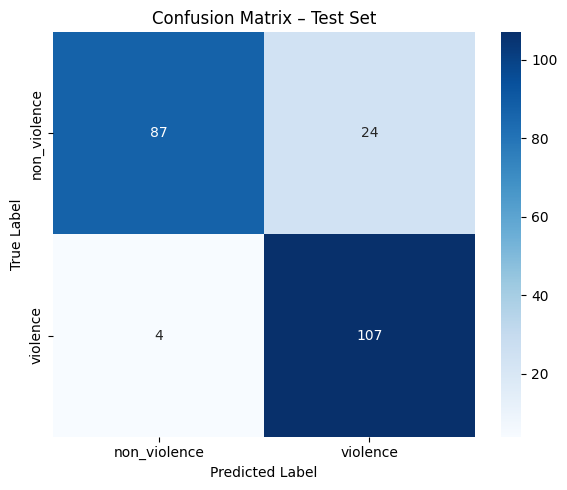


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.96      0.78      0.86       111
    violence       0.82      0.96      0.88       111

    accuracy                           0.87       222
   macro avg       0.89      0.87      0.87       222
weighted avg       0.89      0.87      0.87       222



In [10]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))